### Prerequsite - Upgrade Scikit Learn
The current workspace has scikit-learn v0.19.1 installed. However, you can upgrade scikit-learn to 0.24.x. and use this [OneHotEncoder](https://scikit-learn.org/0.21/modules/generated/sklearn.preprocessing.OneHotEncoder.html) library. 


In [1]:
import sklearn
##print('The scikit-learn version is {}.'.format(sklearn.__version__))

In [2]:
import os
##os.environ['PATH'] = f"{os.environ['PATH']}:/root/.local/bin"

In [3]:
!python -m pip install --upgrade scikit-learn
##import sklearn
##print('The scikit-learn version is {}.'.format(sklearn.__version__))

Requirement already up-to-date: scikit-learn in /opt/conda/lib/python3.6/site-packages (0.24.2)


In [4]:
# Now you can import and use OneHotEncoder
##from sklearn.preprocessing import OneHotEncoder
# your code goes here

In [5]:
# Similarly, should you need any other package, they can install it as:
##!python -m pip install 'tensorflow-tensorboard<0.2.0,>=0.1.0'

# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [6]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer  
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [7]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')
# Load in the feature summary file.
feat_info = pd.read_table('AZDIAS_Feature_Summary.csv',sep=';')

In [8]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

# Print first few rows of Azdias
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,4,0,10.0,0,-1,15.0,4.0,2.0,2.0,1.0,1.0,0,0,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,-1,NaN,NaN,-1,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,1,1996,10.0,0,3,21.0,6.0,5.0,3.0,2.0,1.0,1,14,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3,1.0,0.0,2,5,0.0,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,1,1979,10.0,1,3,3.0,1.0,1.0,1.0,3.0,2.0,1,15,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2,0.0,0.0,1,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,6,1957,1.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,8,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1,0.0,0.0,1,3,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,0.0,4.0,1.0,0.0,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,5,1963,5.0,0,3,32.0,10.0,10.0,5.0,3.0,2.0,1,8,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2,0.0,0.0,2,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [9]:
# Find number of rows and columns of Azdias
print("Number of rows and columns:", azdias.shape)

Number of rows and columns: (891221, 85)


In [10]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [11]:
# Count null values in each column
azdias.isnull().sum()

AGER_TYP                      0
ALTERSKATEGORIE_GROB          0
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR                   0
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP                    0
LP_LEBENSPHASE_FEIN        4854
LP_LEBENSPHASE_GROB        4854
LP_FAMILIE_FEIN            4854
LP_FAMILIE_GROB            4854
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ              0
PRAEGENDE_JUGENDJAHRE         0
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
SEMIO_ERL                     0
SEMIO_KU

In [12]:
# View first few rows of feat_info
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [13]:
# Find number of rows and column for feat_info
print("Number of rows and columns:", feat_info.shape)

Number of rows and columns: (85, 4)


In [14]:
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB


In [15]:
# Count null values for each column
feat_info.isnull().sum()

attribute             0
information_level     0
type                  0
missing_or_unknown    0
dtype: int64

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [16]:
# Identify missing or unknown data values and convert them to NaNs.

# Print number of naturally missing values
print('Naturally missing values: {}'.format(azdias.isnull().sum().sum()))

Naturally missing values: 4896838


In [17]:
# Print total number of missing values after conversion
for indx in range(len(feat_info)):
    missing_or_unknown = feat_info.iloc[indx]['missing_or_unknown']
    missing_or_unknown = missing_or_unknown.strip('[')
    missing_or_unknown = missing_or_unknown.strip(']')
    missing_or_unknown = missing_or_unknown.split(sep=',')
    missing_or_unknown = [int(value) if (value!='X' and value!='XX' and value!='') else value for value in missing_or_unknown]
    if missing_or_unknown != ['']:
        azdias = azdias.replace({feat_info.iloc[indx]['attribute']: missing_or_unknown}, np.nan)
        
print('Total number of missing values after conversion: {}'.format(azdias.isnull().sum().sum()))        

Total number of missing values after conversion: 8373929


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [18]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
percent_missing_per_column =(azdias.isnull().sum()/len(azdias))*100
print(percent_missing_per_column)

AGER_TYP                 76.955435
ALTERSKATEGORIE_GROB      0.323264
ANREDE_KZ                 0.000000
CJT_GESAMTTYP             0.544646
FINANZ_MINIMALIST         0.000000
FINANZ_SPARER             0.000000
FINANZ_VORSORGER          0.000000
FINANZ_ANLEGER            0.000000
FINANZ_UNAUFFAELLIGER     0.000000
FINANZ_HAUSBAUER          0.000000
FINANZTYP                 0.000000
GEBURTSJAHR              44.020282
GFK_URLAUBERTYP           0.544646
GREEN_AVANTGARDE          0.000000
HEALTH_TYP               12.476816
LP_LEBENSPHASE_FEIN      10.954859
LP_LEBENSPHASE_GROB      10.611509
LP_FAMILIE_FEIN           8.728699
LP_FAMILIE_GROB           8.728699
LP_STATUS_FEIN            0.544646
LP_STATUS_GROB            0.544646
NATIONALITAET_KZ         12.153551
PRAEGENDE_JUGENDJAHRE    12.136608
RETOURTYP_BK_S            0.544646
SEMIO_SOZ                 0.000000
SEMIO_FAM                 0.000000
SEMIO_REL                 0.000000
SEMIO_MAT                 0.000000
SEMIO_VERT          

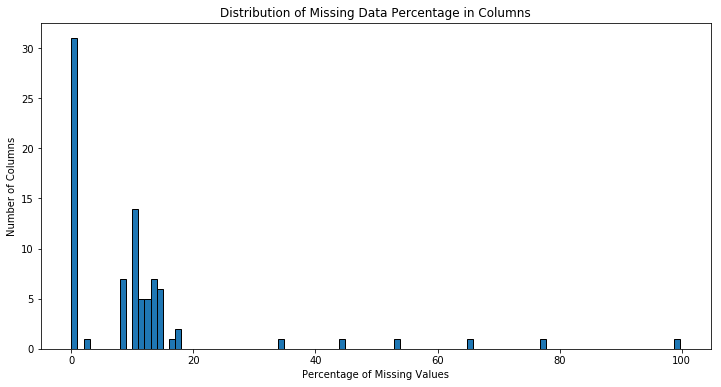

In [19]:
# Investigate patterns in the amount of missing data in each column.
plt.figure(figsize=(12, 6))
plt.hist(percent_missing_per_column, bins=100, edgecolor='k')
plt.ylabel('Number of Columns')
plt.xlabel('Percentage of Missing Values')
plt.title('Distribution of Missing Data Percentage in Columns')
plt.show()

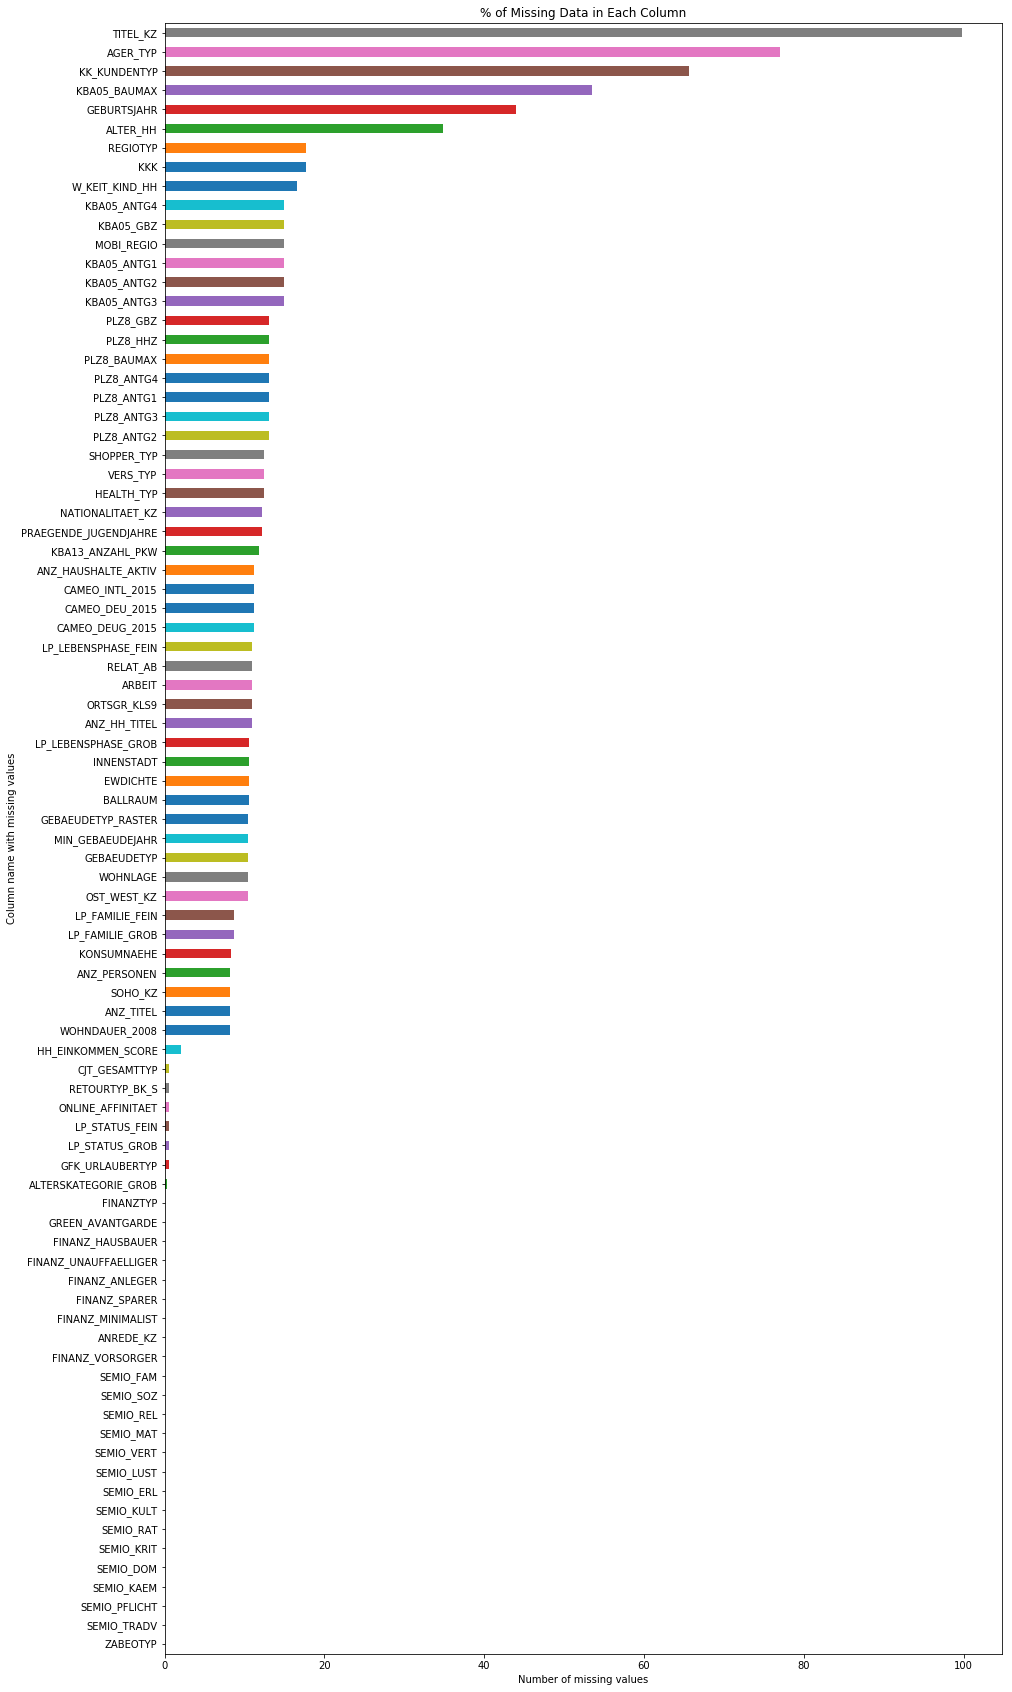

In [20]:
# Sort the columns by the amount of missing data (in ascending order)
percent_missing_per_column_sorted = percent_missing_per_column.sort_values(ascending=True)

# Graph amount of missing data in each column.
percent_missing_per_column_sorted.plot.barh(figsize=(15,30))
plt.xlabel('Number of missing values')
plt.ylabel('Column name with missing values')
plt.title('% of Missing Data in Each Column')
plt.show()

In [21]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

# Caluculate percent missing per column and find columns with more than 20% missing data
percent_missing_per_column_20 = percent_missing_per_column[percent_missing_per_column>20]

In [22]:
# Identiy columns with more than 20% missing data
drop_coloumns = percent_missing_per_column_20.index.tolist()
print('These columns have more than 20 percent missing data, and will be dropped:{}'.format(drop_coloumns))

These columns have more than 20 percent missing data, and will be dropped:['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']


In [23]:
# Drop columns with more than 20% missing data
azdias = azdias.drop(drop_coloumns, axis=1)

In [24]:
# Confirm dropped columns
azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,10.0,0,NaN,15.0,4.0,2.0,2.0,1.0,1.0,NaN,NaN,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,3,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,10.0,0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3.0,1.0,2.0,5,2.0,0.0,6.0,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,10.0,1,3.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2.0,0.0,1.0,5,1.0,0.0,4.0,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,1.0,0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,8.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1.0,0.0,1.0,3,0.0,0.0,1.0,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,5.0,0,3.0,32.0,10.0,10.0,5.0,3.0,2.0,1.0,8.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2.0,0.0,2.0,4,4.0,0.0,5.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [25]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 79 columns):
ALTERSKATEGORIE_GROB     888340 non-null float64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               780025 non-null float64
LP_LEBENSPHASE_FEIN      793589 non-null float64
LP_LEBENSPHASE_GROB      796649 non-null float64
LP_FAMILIE_FEIN          813429 non-null float64
LP_FAMILIE_GROB          813429 non-null float64
LP_STATUS_FEIN           886367 non-null float64
LP_STATUS_GROB           

#### Discussion 1.1.2: Assess Missing Data in Each Column

After assessing the missing data in each column, it was discovered that of the 85 columns within the dataset, 6 of those columns had more than 20% of missing data. Those columns included: 'AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX'. As a result of being outlier columns, the 6 columns were dropped from the dataset, bringing the total number of columns down to 79.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [26]:
# How much data is missing in each row of the dataset?
missing_per_row = azdias.isnull().sum(axis=1)

print(missing_per_row.describe())


count    891221.000000
mean          5.649894
std          13.234687
min           0.000000
25%           0.000000
50%           0.000000
75%           3.000000
max          49.000000
dtype: float64


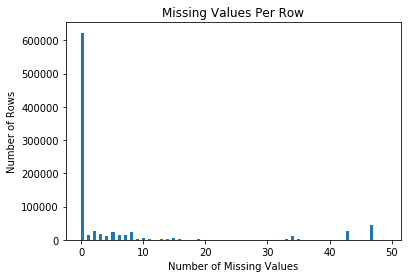

In [27]:
# Graph missing values
plt.hist(missing_per_row, bins=100)
plt.title('Missing Values Per Row')
plt.ylabel('Number of Rows')
plt.xlabel('Number of Missing Values')
plt.show()

In [28]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
threshold = 3
missing_lt_3 = azdias[missing_per_row <= threshold]
missing_mt_3 = azdias[missing_per_row > threshold]
print(f"Rows with less than  or equal to 3 columns of missing data: {missing_lt_3.shape[0]}")
print(f"Row with more than 3 columns of missing data: {missing_mt_3.shape[0]}")

Rows with less than  or equal to 3 columns of missing data: 684502
Row with more than 3 columns of missing data: 206719


In [29]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
zero_missing_coloumns = percent_missing_per_column[percent_missing_per_column==0].index.tolist()
compare_columns = zero_missing_coloumns[:6]

print(f"Columns to compare distribution of values: {compare_columns}")

Columns to compare distribution of values: ['ANREDE_KZ', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER']


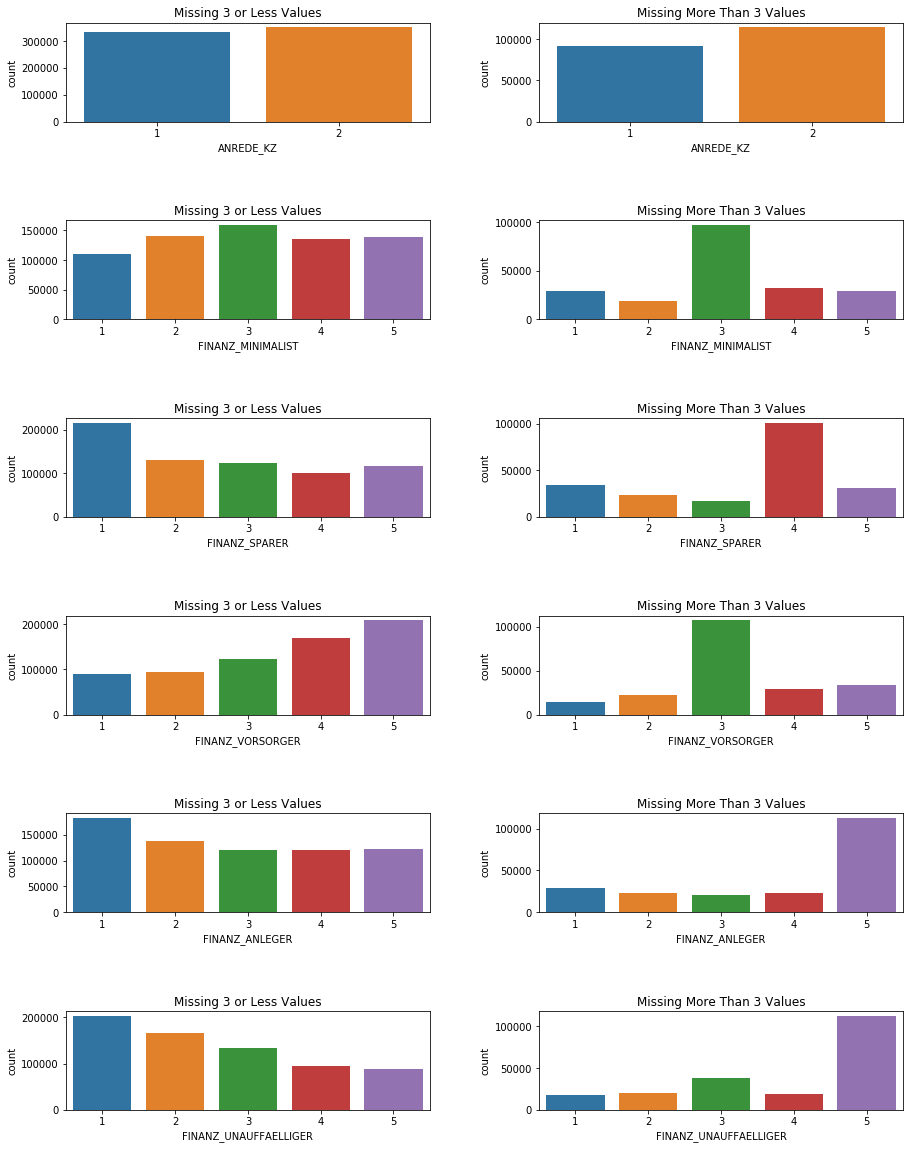

In [30]:
# Plot distribution of values
figure, axs = plt.subplots(nrows=len(compare_columns), ncols=2, figsize = (15,20))
figure.subplots_adjust(hspace = 1, wspace=.3)
for i in range(len(compare_columns)):
    sns.countplot(missing_lt_3[compare_columns[i]], ax=axs[i][0])
    axs[i][0].set_title('Missing 3 or Less Values')
    sns.countplot(missing_mt_3[compare_columns[i]], ax=axs[i][1])
    axs[i][1].set_title('Missing More Than 3 Values')

#### Discussion 1.1.3: Assess Missing Data in Each Row

The data was seperated in two datasets, the first dataset has rows with 3 or less missing values and the second dataset has rows with more than 3 missing values. Then, I plotted them on 6 columns without missing values, which are: 'ANREDE_KZ', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER'.


The columns above are translated from German into English below and are defined:
1. ANREDE_KZ: Salutation Code. Refers to a code representing forms of address, such as "Mr.", "Mrs.", "Ms.", etc.
2. FINANZ_MINIMALIST: Finance Minimalist. Someone who prefers to keep financial matters simple, possibly with minimal spending or investment.
3. FINANZ_SPARER: Finance Saver. Someone who prioritizes saving money over spending or investing.
4. FINANZ_VORSORGER: Finance Planner. Someone who plans their finances carefully, possibly with a focus on future financial security.
5. FINANZ_ANLEGER: Finance Investor. Someone who actively invests their money in various financial products or assets.
6. FINANZ_UNAUFFAELLIGER: Finance Unremarkable. Someone whose financial behavior doesn't stand out, possibly implying they are cautious or average in their financial decisions.


It can be observed in the charts above that the distributions of values are similar for 'ANREDE_KZ', which suggest gender does not affect the distributions values. Further observation shows a notable differnece between the finance features. These differences suggest that the financial category of an individual affects the distributions values.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [52]:
# How many features are there of each data type?
features = list(missing_lt_3.columns)
feat_info_clean = feat_info[feat_info['attribute'].isin(features)]
data_type_count = feat_info_clean['type'].value_counts()
for i in range(len(data_type_count)):
    print('There are {} {} features.'.format(data_type_count[i], data_type_count.index[i]))

There are 49 ordinal features.
There are 18 categorical features.
There are 6 mixed features.
There are 6 numeric features.


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [60]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
cat_features = feat_info_clean[feat_info_clean["type"]=="categorical"]["attribute"]

binary_feature = []
multi_level_feature=[]
for feature in cat_features:
    if (len(missing_lt_3[feature].unique())==2):
        binary_feature.append(feature)
    elif (len(missing_lt_3[feature].unique())>2):
        multi_level_feature.append(feature)
        
print('Binary features are: {}'.format(binary_feature))
print('Multi-level features are: {}'.format(multi_level_feature))        

Binary features are: ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']
Multi-level features are: ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [56]:
for feature in binary_feature:
    print('Unique values for {} are {}'.format(feature, missing_lt_3[feature].unique()))

Unique values for ANREDE_KZ are [2 1]
Unique values for GREEN_AVANTGARDE are [0 1]
Unique values for SOHO_KZ are [1. 0.]
Unique values for VERS_TYP are [2. 1.]
Unique values for OST_WEST_KZ are ['W' 'O']


In [58]:
# Re-encode categorical variable(s) to be kept in the analysis.
new_values = {'W': 0, 'O': 1}
azdias_clean = missing_lt_3.replace({'OST_WEST_KZ':new_values})

In [59]:
# Drop multi-level features
for feature in multi_level_feature:
    azdias_clean=azdias_clean.drop(feature, axis=1)

#### Discussion 1.2.1: Re-Encode Categorical Features

First, I assessed the categorical variables to determined which are binary, which are multi-level, and which ones needed to be re-encoded. The following categorical variables returned as binary features: 'ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ'. In addition, the results revealed that 'OST_WEST_KZ' needed to be re-encoded as numbers in order to be kept in the analysis. After re-encoding 'OST_WEST_KZ', all multi-level features were dropped.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [61]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
azdias_clean['DECADE'] = azdias_clean['PRAEGENDE_JUGENDJAHRE']
azdias_clean['MOVEMENT'] = azdias_clean['PRAEGENDE_JUGENDJAHRE']

In [62]:
decade_dict = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
movement_dict = {1:1, 2:0, 3:1, 4:0, 5:1, 6:0, 7:0, 8:1, 9:0, 10:1, 11:0, 12:1, 13:0, 14:1, 15:0}

In [63]:
azdias_clean['DECADE'].replace(decade_dict, inplace=True)
azdias_clean['MOVEMENT'].replace(movement_dict, inplace=True)

In [64]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
azdias_clean['WEALTH'] = azdias_clean['CAMEO_INTL_2015']
azdias_clean['LIFE_STAGE'] = azdias_clean['CAMEO_INTL_2015']

In [65]:
wealth_dict = {'11':1, '12':1, '13':1, '14':1, '15':1, '21':2, '22':2, '23':2, '24':2, '25':2,
               '31':3, '32':3, '33':3, '34':3, '35':3, '41':4, '42':4, '43':4, '44':4, '45':4,
               '51':5, '52':5, '53':5, '54':5, '55':5}

life_stage_dict = {'11':1, '12':2, '13':3, '14':4, '15':5, '21':1, '22':2, '23':3, '24':4, '25':5,
                   '31':1, '32':2, '33':3, '34':4, '35':5, '41':1, '42':2, '43':3, '44':4, '45':5,
                   '51':1, '52':2, '53':3, '54':4, '55':5}

In [66]:
azdias_clean['WEALTH'].replace(wealth_dict, inplace=True)
azdias_clean['LIFE_STAGE'].replace(life_stage_dict, inplace=True)

#### Discussion 1.2.2: Engineer Mixed-Type Features

The two mixed-value features, 'PRAEGENDE_JUGENDJAHRE and' 'CAMEO_INTL_2015' were kept. To engineer these two mixed-value features, I created two new feature columns, and copied values from the intial mixed-value feature column. Next, I created two dictionaries to map intial feature values to new feature values, and then, performed a replace operation using the dictionaries on the new feature columns. Lastly, the other four mixed-values features were dropped.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [36]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

In [67]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
mixed_features = feat_info_clean[feat_info_clean["type"]=="mixed"]["attribute"]
for feature in mixed_features:
    azdias_clean.drop(feature, axis=1, inplace=True)

In [69]:
azdias_clean.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
1,1.0,2,1,5,2,5,4,5,0,3.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,1.0,2.0,2.0,0.0,6.0,3.0,9.0,11.0,0.0,1.0,1992.0,0,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,5.0,4.0,3.0,5.0,4.0,6.0,1.0,5.0,1.0
2,3.0,2,1,4,1,2,3,5,1,3.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,0.0,1.0,1.0,0.0,4.0,3.0,9.0,10.0,0.0,5.0,1992.0,0,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,4.0,4.0,3.0,5.0,2.0,6.0,0.0,2.0,4.0
4,3.0,1,4,3,4,1,3,2,0,3.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,0.0,2.0,4.0,0.0,5.0,2.0,9.0,3.0,0.0,4.0,1992.0,0,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,3.0,3.0,4.0,6.0,5.0,4.0,1.0,4.0,3.0
5,1.0,2,3,1,5,2,2,5,0,3.0,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,0.0,2.0,1.0,0.0,5.0,6.0,9.0,5.0,0.0,5.0,1992.0,0,2.0,2.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,2.0,1.0,5.0,4.0
6,2.0,2,1,5,1,5,4,3,0,2.0,4.0,2,5,5,7,2,6,5,5,7,7,4,7,7,7,0.0,1.0,1.0,0.0,6.0,3.0,9.0,4.0,0.0,5.0,1992.0,0,3.0,2.0,0.0,0.0,3.0,6.0,4.0,3.0,5.0,3.0,5.0,2.0,5.0,867.0,3.0,3.0,1.0,0.0,5.0,5.0,4.0,6.0,3.0,5.0,1.0,2.0,2.0


In [70]:
azdias_clean.shape

(684502, 64)

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [124]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    for indx in range(len(feat_info)):
        missing_or_unknown = feat_info.iloc[indx]['missing_or_unknown']
        missing_or_unknown = missing_or_unknown.strip('[')
        missing_or_unknown = missing_or_unknown.strip(']')
        missing_or_unknown = missing_or_unknown.split(sep=',')
        missing_or_unknown = [int(value) if (value!='X' and value!='XX' and value!='') else value for value in missing_or_unknown]
        if missing_or_unknown != ['']:
            df_clean = df.replace({feat_info.iloc[indx]['attribute']: missing_or_unknown}, np.nan)
    
    for col in df.columns:
        df_clean = df_clean.replace({col: ['XX', 'X']}, np.nan)
    
    # remove selected columns and rows, ...
    # drop columns with more than 20% missing values
    columns_miss_20 = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
    df_clean = df_clean.drop(columns_miss_20, axis=1)
    # drop rows with more than 3 missing values
    df_clean = df_clean[df_clean.isnull().sum(axis=1) <= 3]
    
    # re-encode binary feature
    new_values = {'W': 0, 'O': 1}
    df_clean = df_clean.replace({'OST_WEST_KZ':new_values})
    
    # drop multi-leve features
    cat_features = feat_info_clean[feat_info_clean["type"]=="categorical"]["attribute"]
    multi_level_feature=[]
    for feature in cat_features:
        if (len(missing_lt_3[feature].unique())>2):
            multi_level_feature.append(feature)
    for feature in multi_level_feature:
        df_clean=df_clean.drop(feature, axis=1)
    
    # engineer mixed features
    df_clean['DECADE'] = df_clean['PRAEGENDE_JUGENDJAHRE']
    df_clean['MOVEMENT'] = df_clean['PRAEGENDE_JUGENDJAHRE']
    
    decade_dict = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
    movement_dict = {1:1, 2:0, 3:1, 4:0, 5:1, 6:0, 7:0, 8:1, 9:0, 10:1, 11:0, 12:1, 13:0, 14:1, 15:0}
    
    df_clean['DECADE'].replace(decade_dict, inplace=True)
    df_clean['MOVEMENT'].replace(movement_dict, inplace=True)
    
    df_clean['WEALTH'] = df_clean['CAMEO_INTL_2015']
    df_clean['LIFE_STAGE'] = df_clean['CAMEO_INTL_2015']
    
    wealth_dict = {'11':1, '12':1, '13':1, '14':1, '15':1, '21':2, '22':2, '23':2, '24':2, '25':2,
                   '31':3, '32':3, '33':3, '34':3, '35':3, '41':4, '42':4, '43':4, '44':4, '45':4,
                   '51':5, '52':5, '53':5, '54':5, '55':5}
    
    life_stage_dict = {'11':1, '12':2, '13':3, '14':4, '15':5, '21':1, '22':2, '23':3, '24':4, '25':5,
                       '31':1, '32':2, '33':3, '34':4, '35':5, '41':1, '42':2, '43':3, '44':4, '45':5,
                       '51':1, '52':2, '53':3, '54':4, '55':5}
    
    df_clean['WEALTH'].replace(wealth_dict, inplace=True)
    df_clean['LIFE_STAGE'].replace(life_stage_dict, inplace=True)
    
    mixed_features = feat_info_clean[feat_info_clean["type"]=="mixed"]["attribute"]
    for feature in mixed_features:
        df_clean.drop(feature, axis=1, inplace=True)
    
   # Return the cleaned dataframe.
    return df_clean
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [73]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
fill_missing = SimpleImputer(strategy='most_frequent')
azdias_clean_imputed = pd.DataFrame(fill_missing.fit_transform(azdias_clean))

azdias_clean_imputed.columns = azdias_clean.columns
azdias_clean_imputed.index = azdias_clean.index

In [74]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler() 
azdias_clean_scaled = scaler.fit_transform(azdias_clean_imputed)

In [75]:
azdias_clean_scaled = pd.DataFrame(azdias_clean_scaled, columns=list(azdias_clean_imputed))
azdias_clean_scaled.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,-1.747634,0.975423,-1.523655,1.588878,-1.050212,1.513292,1.048651,1.341142,-0.542999,1.038860,-1.658358,0.397109,-0.043994,0.062612,-0.427834,-1.741122,-1.103348,-1.427354,-0.587237,1.303149,-0.284313,1.308015,-0.141193,1.535987,1.251532,10.853382,0.944279,0.181309,-0.060653,1.001008,-0.710036,0.54457,0.173720,-0.127933,-1.305042,-0.393211,-0.528845,-1.078177,-1.015460,-0.610863,2.689063,-1.640359,0.843369,-0.553878,1.703668,-0.804562,-0.781025,-1.395988,0.162727,-0.860038,1.022332,-0.258419,0.212410,0.403636,0.409122,1.432172,0.564740,-0.187976,-0.133875,0.678924,1.144730,0.542999,1.169744,-1.255608
1,0.193497,0.975423,-1.523655,0.908468,-1.771419,-0.548762,0.320698,1.341142,1.841624,1.038860,-0.283502,-0.114397,-1.607366,-0.475089,-0.427834,-0.161203,-0.147936,0.776532,-0.587237,0.096564,1.434730,1.308015,1.443814,-0.593355,-0.434856,-0.092137,-1.059009,-0.700290,-0.060653,-0.294759,-0.710036,0.54457,0.108448,-0.127933,1.286438,-0.393211,-0.528845,-0.369781,1.403675,0.376791,-0.470347,-0.134270,-0.985743,0.028444,-0.267411,0.285159,-0.781025,0.002427,-0.479994,-1.411535,0.280189,0.766897,0.212410,-0.609339,-0.963869,0.402503,0.564740,-0.187976,-0.133875,-0.799090,1.144730,-1.841624,-0.873113,0.753418
2,0.193497,-1.025197,0.677626,0.228057,0.392200,-1.236113,0.320698,-0.834925,-0.542999,1.038860,1.091354,0.908616,-0.043994,0.062612,-0.941942,1.418716,-0.147936,-0.325411,0.929047,-1.110022,-0.857327,-1.397371,-1.197864,-0.061020,-0.996986,-0.092137,0.944279,1.944505,-0.060653,0.353124,-1.278694,0.54457,-0.348461,-0.127933,0.638568,-0.393211,-0.528845,-0.369781,2.210054,0.376791,-0.470347,-0.134270,-0.985743,0.610766,-1.745720,1.374880,0.268224,0.002427,1.448168,0.242954,-0.538830,-0.258419,1.299133,0.403636,0.409122,-0.627167,-0.334972,0.816965,0.301888,1.417930,-0.232759,0.542999,0.488792,0.083743
3,-1.747634,0.975423,-0.056134,-1.132765,1.113406,-0.548762,-0.407255,1.341142,-0.542999,1.038860,-0.283502,-1.137410,-0.043994,1.675713,0.086274,-1.214482,-1.103348,-1.427354,0.423619,1.906442,-0.284313,-0.315217,-0.141193,1.535987,1.251532,-0.092137,0.944279,-0.700290,-0.060653,0.353124,0.995939,0.54457,-0.217915,-0.127933,1.286438,-0.393211,-0.528845,0.338616,0.597297,-0.610863,-0.470347,0.618774,0.843369,-1.136199,1.210898,0.285159,1.317473,0.701634,-1.122715,0.242954,2.018755,-0.258419,0.212410,-0.609339,0.409122,1.432172,1.464451,-1.192917,-1.005401,-0.060083,-1.610248,0.542999,1.169744,0.753418
4,-0.777068,0.975423,-1.523655,1.588878,-1.771419,1.513292,1.048651,-0.109569,-0.542999,-0.285764,0.403926,-1.137410,0.477130,0.600312,1.628598,-1.214482,0.807475,0.225560,0.423619,1.906442,1.434730,-0.315217,1.443814,1.535987,1.813662,-0.092137,-1.059009,-0.700290,-0.060653,1.001008,-0.710036,0.54457,-0.283188,-0.127933,1.286438,-0.393211,-0.528845,1.047012,0.597297,-0.610863,-0.470347,-0.134270,0.843369,0.028444,-0.760181,1.374880,0.268224,1.400842,-0.479994,0.242954,0.738484,0.766897,0.212410,-0.609339,-0.963869,1.432172,1.464451,0.816965,0.301888,-0.060083,0.455986,0.542999,-0.873113,-0.585933


### Discussion 2.1: Apply Feature Scaling

Using the Imputer method, all missing values have been replaced with the most frequent value in that particular column. Then feature scaling was appied to the general population demographics data using StandardScaler.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [76]:
# Apply PCA to the data.
pca = PCA()
pca.fit(azdias_clean_scaled)

PCA()

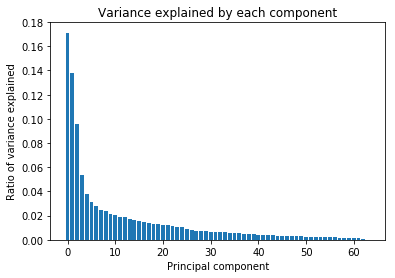

In [77]:
# Investigate the variance accounted for by each principal component.
plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)
plt.title("Variance explained by each component")
plt.xlabel("Principal component")
plt.ylabel("Ratio of variance explained")
plt.show()


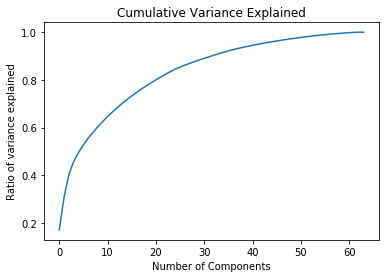

In [78]:
# Investigate the cumulative variance of the principal components
plt.plot(range(len(pca.explained_variance_ratio_)),np.cumsum(pca.explained_variance_ratio_), '-')
plt.title("Cumulative Variance Explained")
plt.xlabel("Number of Components")
plt.ylabel("Ratio of variance explained")
plt.show()

In [79]:
# Re-apply PCA to the data while selecting for number of components to retain.

# To retain 30 components
pca_30 = PCA(n_components=30)
azdias_pca = pca_30.fit_transform(azdias_clean_scaled)

### Discussion 2.2: Perform Dimensionality Reduction

I applied PCA to the cleaned and scaled dataset to reduce its dimensionality while retaining as much variance as possible. First, PCA is performed without specifying the number of components, and the variance explained by each principal component is visualized using a bar plot. This helps to understand how much of the dataset's variance each component captures. Then, a cumulative variance plot is created to see how much total variance is explained as more components are included. Finally, I re-applied PCA, this time retaining only the top 30 components, which are then used to transform the dataset, reducing its dimensionality while preserving the most important information.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [84]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def pca_weights(pca, i):
    df = pd.DataFrame(pca.components_, columns=list(azdias_clean_scaled.columns))
    weights = df.iloc[i].sort_values(ascending=False)
    return weights

# Retrieve weights for the first principal component
pca_weight_0 = pca_weights(pca_30, 0)

# Print top 10 positive weights
print("Top 10 Positive Weights:")
print(pca_weight_0.head(10))

# Print top 10 negative weights
print("\nTop 10 Negative Weights:")
print(pca_weight_0.tail(10))

Top 10 Positive Weights:
PLZ8_ANTG3            0.220711
PLZ8_ANTG4            0.214165
WEALTH                0.201747
HH_EINKOMMEN_SCORE    0.199923
ORTSGR_KLS9           0.190927
EWDICHTE              0.188370
FINANZ_SPARER         0.154826
FINANZ_HAUSBAUER      0.153379
KBA05_ANTG4           0.150497
PLZ8_ANTG2            0.148882
Name: 0, dtype: float64

Top 10 Negative Weights:
FINANZ_VORSORGER       -0.124331
ALTERSKATEGORIE_GROB   -0.135227
INNENSTADT             -0.159287
KONSUMNAEHE            -0.162624
PLZ8_GBZ               -0.163857
KBA05_GBZ              -0.214052
PLZ8_ANTG1             -0.221102
FINANZ_MINIMALIST      -0.221245
KBA05_ANTG1            -0.222708
MOBI_REGIO             -0.238902
Name: 0, dtype: float64


In [85]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

# Retrieve weights for the second principal component
pca_weight_1 = pca_weights(pca_30, 1)

# Print top 10 positive weights
print("Top 10 Positive Weights for the Second Principal Component:")
print(pca_weight_1.head(10))

# Print top 10 negative weights
print("\nTop 10 Negative Weights for the Second Principal Component:")
print(pca_weight_1.tail(10))

Top 10 Positive Weights for the Second Principal Component:
ALTERSKATEGORIE_GROB    0.252939
SEMIO_ERL               0.228755
FINANZ_VORSORGER        0.221934
SEMIO_LUST              0.177210
RETOURTYP_BK_S          0.162699
FINANZ_HAUSBAUER        0.124830
SEMIO_KRIT              0.121044
W_KEIT_KIND_HH          0.115419
SEMIO_KAEM              0.113679
PLZ8_ANTG3              0.105631
Name: 1, dtype: float64

Top 10 Negative Weights for the Second Principal Component:
SEMIO_RAT               -0.166629
SEMIO_FAM               -0.177330
FINANZ_ANLEGER          -0.200528
SEMIO_KULT              -0.217151
FINANZ_UNAUFFAELLIGER   -0.220778
SEMIO_TRADV             -0.224854
FINANZ_SPARER           -0.226785
SEMIO_PFLICHT           -0.227848
DECADE                  -0.234656
SEMIO_REL               -0.258086
Name: 1, dtype: float64


In [86]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

# Retrieve weights for the third principal component
pca_weight_2= pca_weights(pca_30, 2)

# Print top 10 positive weights
print("Top 10 Positive Weights for the Third Principal Component:")
print(pca_weight_2.head(10))

# Print top 10 negative weights
print("\nTop 10 Negative Weights for the Third Principal Component:")
print(pca_weight_2.tail(10))

Top 10 Positive Weights for the Third Principal Component:
SEMIO_VERT              0.347771
SEMIO_SOZ               0.263247
SEMIO_FAM               0.250498
SEMIO_KULT              0.231953
FINANZ_MINIMALIST       0.157938
RETOURTYP_BK_S          0.116842
FINANZ_VORSORGER        0.100528
W_KEIT_KIND_HH          0.090749
ALTERSKATEGORIE_GROB    0.084443
SEMIO_REL               0.078693
Name: 2, dtype: float64

Top 10 Negative Weights for the Third Principal Component:
FINANZ_UNAUFFAELLIGER   -0.094608
FINANZ_SPARER           -0.103610
DECADE                  -0.108221
SEMIO_ERL               -0.169458
FINANZ_ANLEGER          -0.189673
SEMIO_RAT               -0.217304
SEMIO_KRIT              -0.268380
SEMIO_DOM               -0.312446
SEMIO_KAEM              -0.336687
ANREDE_KZ               -0.368244
Name: 2, dtype: float64


### Discussion 2.3: Interpret Principal Components

**First Principal Component**

* Top Positive Values
    * PLZ8_ANTG3: Number of 6-10 family houses in the PLZ8 region
    * PLZ8_ANTG4: Number of 10+ family houses in the PLZ8 region
    * WEALTH: Household wealthy
        
* Top Negative Values
    * FINANZ_MINIMALIST: Financial typology - low financial interest
    * KBA05_ANTG1: Number of 1-2 family houses in the PLZ8 region
    * MOBI_REGIO: Movement patterns 
        
The first principal component is driven by location-based features, with wealthier, densely populated areas contributing positively, while regions with lower mobility and older infrastructure are negatively associated. This suggests a focus on contrasting affluent regions with traditional, less developed ones.


**Second Principal Component**

* Top Positive Values
    * ALTERSKATEGORIE_GROB: Estimated age based on given name analysis
    * SEMIO_ERL: personality typology - Event-oriented
    * FINANZ_VORSORGER: Financial typology - be prepared

* Top Negative Values
    * SEMIO_PFLICHT: Personality typology - Dutiful
    * DECADE: Generation
    * SEMIO_REL: Personality typology - Religious

The second principal component reflects age and financial behaviors, where older age groups and prudent financial planning are positively weighted. Traditional values and older generations are negatively correlated, indicating a divide between progressive financial habits and more conservative demographics.


**Third Principal Component**

* Top Positive Values
    * SEMIO_VERT: personality typology - dreamful
    * SEMIO_SOZ: personality typology - socially-minded
    * SEMIO_FAM: personality typology - family-minded 

* Top Negative Values
    * SEMIO_DOM: personality typology - dominant-minded
    * SEMIO_KAEM: personality typology - combative attitude
    * ANREDE_KZ: Gender

The third principal component emphasizes social hierarchy and connections, with positive weights for features related to social structure. Negative weights suggest less emphasis on traditional roles and combative behaviors, highlighting a distinction between individuals who value social order and those who do not.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [105]:
from sklearn.cluster import MiniBatchKMeans
# Over a number of different cluster counts...
ks = list(range(1, 30))  # Testing for cluster counts from 1 to 30
scores = []

# run k-means clustering on the data and...
for k in ks:
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=1024)
    kmeans.fit(azdias_pca)
    # compute the average within-cluster distances.
    score = -kmeans.score(azdias_pca)  # score is negative, so take the negative to get positive SSE
    scores.append(score)

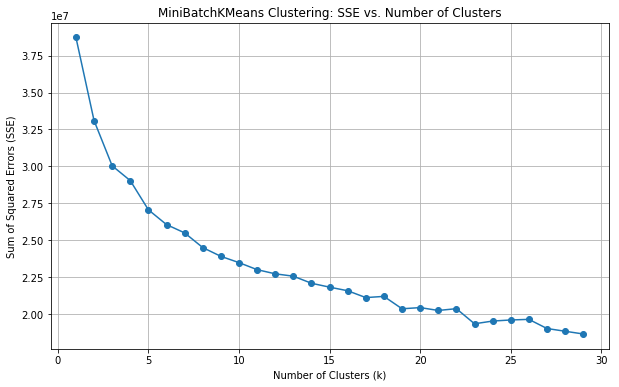

In [106]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.figure(figsize=(10, 6))
plt.plot(ks, scores, linestyle='-', marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.title('MiniBatchKMeans Clustering: SSE vs. Number of Clusters')
plt.grid(True)
plt.show()

In [137]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

# Re-fit the MiniBatchKMeans model with the selected number of clusters
optimal_k = 13
final_kmeans = MiniBatchKMeans(n_clusters=optimal_k, random_state=42, batch_size=1024)
model_13 = final_kmeans.fit(azdias_pca)
# Obtain cluster predictions for the general population demographics data
azdias_pred = final_kmeans.predict(azdias_pca)

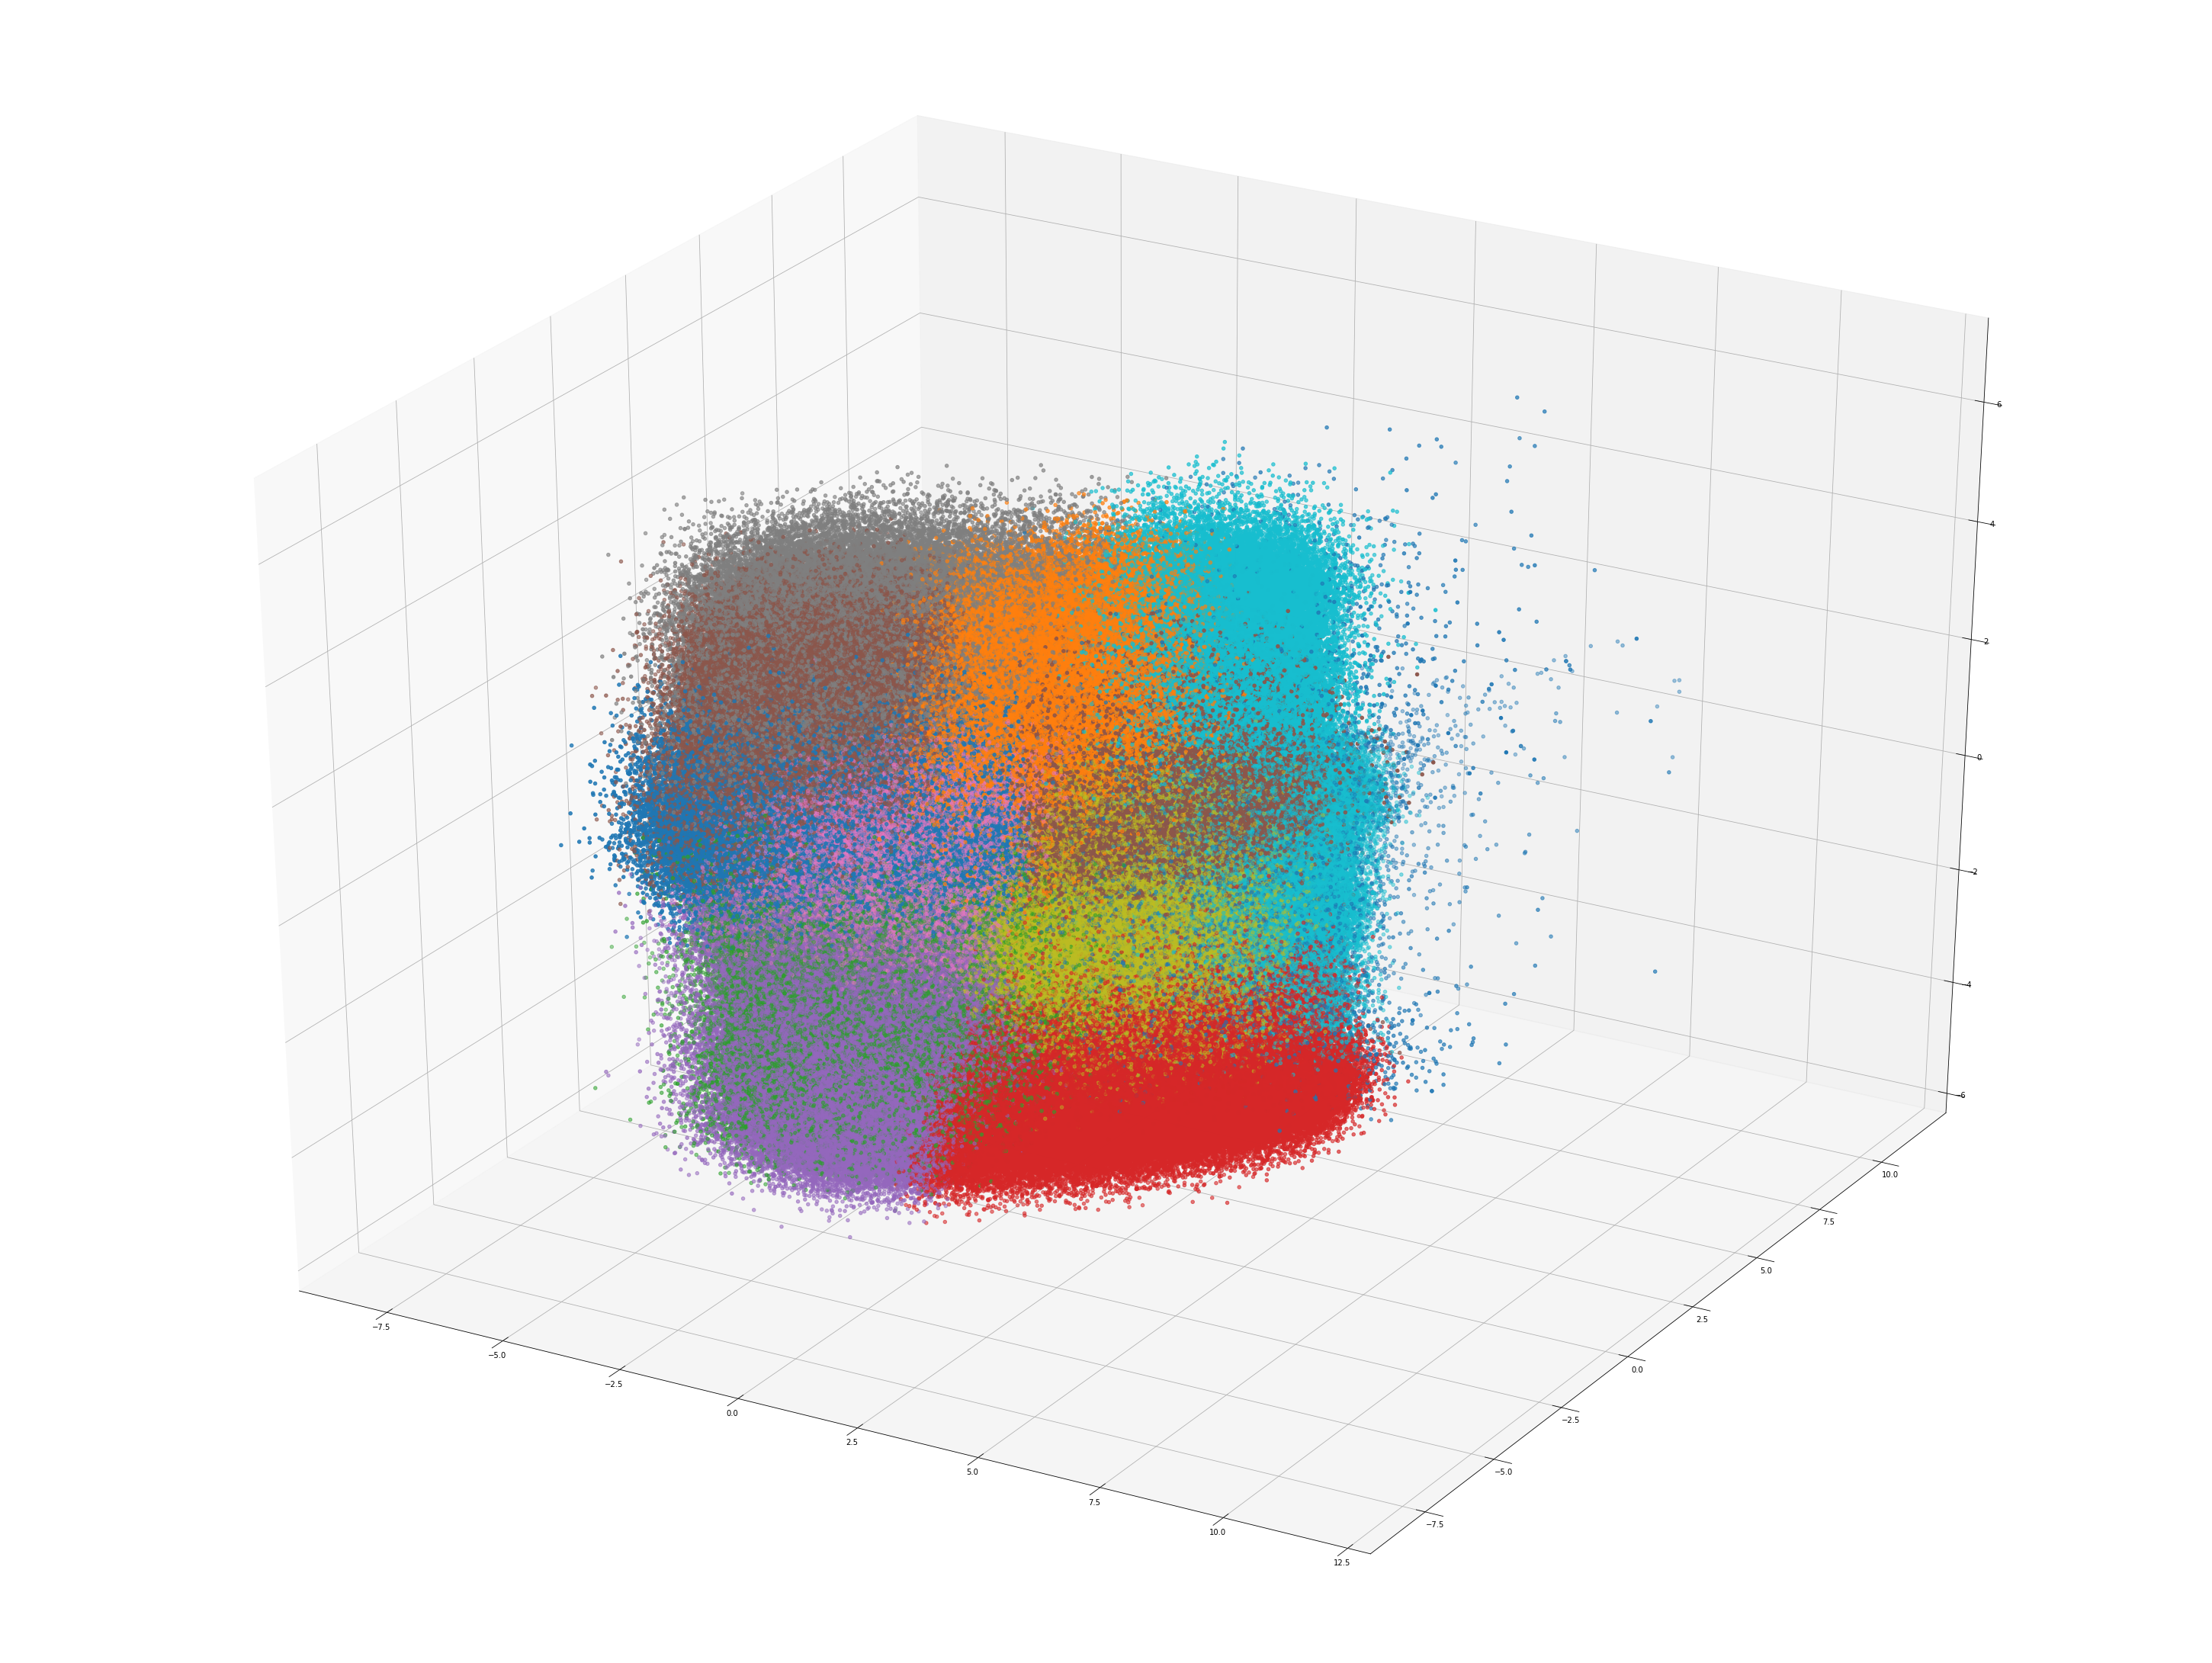

In [135]:
from mpl_toolkits.mplot3d import Axes3D
def create_kmeans_plot(data, labels): 
    fig = plt.figure(figsize=(40, 30));
    ax = Axes3D(fig)
    ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=labels, cmap='tab10');
    

create_kmeans_plot(azdias_pca, azdias_predictions)

### Discussion 3.1: Apply Clustering to General Population

MiniBatchKMeans was applied to the data using a batch size of 1024 to reduce run time. A plot was then created to investigate the change in within-cluster distance across number of clusters. A review of the plot revealed the elbow appearing at 13 clusters. 

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [120]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv',delimiter=';')

In [121]:
customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,2,0,4.0,1,1,20.0,5.0,2.0,2.0,10.0,5.0,1,4,5.0,6,5,2,6,6,7,3,4,1,3,1,1,2,1,3,0.0,0.0,1,3,10.0,2.0,0.0,1.0,NaN,6.0,9.0,1.0,0.0,1.0,5.0,1992.0,W,7.0,1,1A,13,2.0,2.0,0.0,0.0,0.0,4.0,3.0,2.0,4.0,4.0,1.0,4.0,3.0,1.0,1201.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,2,0,NaN,0,1,NaN,NaN,NaN,NaN,NaN,NaN,1,0,NaN,3,6,2,6,7,5,3,4,1,3,3,2,4,1,3,0.0,0.0,1,3,11.0,3.0,0.0,NaN,NaN,0.0,9.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,2,0,3.0,1,2,13.0,3.0,1.0,1.0,10.0,5.0,1,4,5.0,2,2,1,3,3,7,7,1,2,7,5,6,4,1,1,0.0,0.0,2,3,6.0,1.0,0.0,1.0,NaN,6.0,9.0,1.0,0.0,8.0,1.0,1992.0,W,2.0,5,5D,34,2.0,2.0,0.0,0.0,0.0,3.0,7.0,4.0,1.0,3.0,3.0,3.0,1.0,7.0,433.0,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,6,0,10.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,1,3.0,6,5,3,4,7,5,3,4,3,3,3,3,3,4,0,0.0,0.0,1,1,8.0,0.0,0.0,4.0,NaN,NaN,9.0,0.0,NaN,2.0,2.0,1992.0,W,7.0,4,4C,24,3.0,0.0,0.0,0.0,1.0,4.0,7.0,1.0,7.0,4.0,3.0,4.0,2.0,6.0,755.0,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,2,1960,2.0,0,3,31.0,10.0,10.0,5.0,1.0,1.0,1,8,5.0,4,5,4,6,5,6,4,5,5,3,5,2,5,4,1,0.0,0.0,2,1,20.0,4.0,0.0,6.0,2.0,2.0,9.0,7.0,0.0,3.0,1.0,1992.0,W,3.0,7,7B,41,0.0,3.0,2.0,0.0,0.0,3.0,3.0,4.0,4.0,3.0,4.0,3.0,5.0,7.0,513.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [126]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customers_clean = clean_data(customers)

In [127]:
# Replace NaN
customers_clean_imputed = pd.DataFrame(fill_missing.fit_transform(customers_clean))
customers_clean_imputed.columns = customers_clean.columns
customers_clean_imputed.index = customers_clean.index

In [128]:
# Apply scaler
customers_clean_scaled = scaler.transform(customers_clean_imputed)
customers_clean_scaled = pd.DataFrame(customers_clean_scaled, columns=list(customers_clean_imputed))
# PCA transformation
customers_pca = pca_30.transform(customers_clean_scaled)

In [132]:
# Predict using Kmeans 
customers_pred = model_13.predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

Text(0.5,1,'General Clusters')

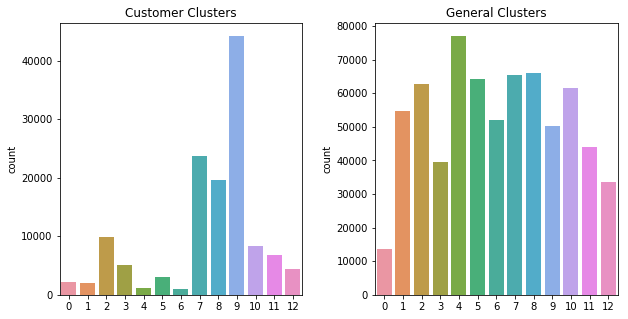

In [144]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
figure, axs = plt.subplots(nrows=1, ncols=2, figsize = (10,5))
figure.subplots_adjust(hspace = 1, wspace=.3)

sns.countplot(customers_pred, ax=axs[0])
axs[0].set_title('Customer Clusters')
sns.countplot(azdias_pred, ax=axs[1])
axs[1].set_title('General Clusters')


In [139]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
centroid_9 = scaler.inverse_transform(pca_30.inverse_transform(model_13.cluster_centers_[9]))


In [141]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
overrepresented_c = pd.Series(data = centroid_9, index = customers_clean.columns)


In [142]:
overrepresented_c

ALTERSKATEGORIE_GROB        3.336894
ANREDE_KZ                   1.041964
FINANZ_MINIMALIST           4.799757
FINANZ_SPARER               1.536887
FINANZ_VORSORGER            4.273789
FINANZ_ANLEGER              1.306986
FINANZ_UNAUFFAELLIGER       2.068161
FINANZ_HAUSBAUER            2.063691
GREEN_AVANTGARDE            0.969370
HEALTH_TYP                  2.006680
RETOURTYP_BK_S              4.067510
SEMIO_SOZ                   4.901462
SEMIO_FAM                   4.880204
SEMIO_REL                   3.765207
SEMIO_MAT                   4.096151
SEMIO_VERT                  6.249719
SEMIO_LUST                  5.405206
SEMIO_ERL                   4.069778
SEMIO_KULT                  4.927229
SEMIO_RAT                   2.721640
SEMIO_KRIT                  3.072629
SEMIO_DOM                   3.347856
SEMIO_KAEM                  2.590164
SEMIO_PFLICHT               3.153599
SEMIO_TRADV                 3.207139
SOHO_KZ                     0.008361
VERS_TYP                    1.506873
A

In [148]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
centroid_4 = scaler.inverse_transform(pca_30.inverse_transform(model_13.cluster_centers_[4]))

In [149]:
underrepresented_c = pd.Series(data = centroid_4, index = customers_clean.columns)


In [150]:
underrepresented_c

ALTERSKATEGORIE_GROB        1.459282
ANREDE_KZ                   2.021947
FINANZ_MINIMALIST           1.293277
FINANZ_SPARER               4.251908
FINANZ_VORSORGER            2.175755
FINANZ_ANLEGER              4.256652
FINANZ_UNAUFFAELLIGER       3.720571
FINANZ_HAUSBAUER            4.031131
GREEN_AVANTGARDE            0.022942
HEALTH_TYP                  2.176802
RETOURTYP_BK_S              2.339807
SEMIO_SOZ                   3.014523
SEMIO_FAM                   3.921744
SEMIO_REL                   5.446908
SEMIO_MAT                   5.308593
SEMIO_VERT                  2.245296
SEMIO_LUST                  2.548212
SEMIO_ERL                   3.983311
SEMIO_KULT                  4.269500
SEMIO_RAT                   6.502335
SEMIO_KRIT                  5.451236
SEMIO_DOM                   6.262136
SEMIO_KAEM                  6.073010
SEMIO_PFLICHT               6.447163
SEMIO_TRADV                 6.162882
SOHO_KZ                     0.008232
VERS_TYP                    1.445653
A

### Discussion 3.3: Compare Customer Data to Demographics Data

From the anaylsis above, it can be seen that

Cluster 9 is overrepresented in the customers data compared to general population data. Some characteristics of the group of population that are relative popular with the mail-order company:

* in areas where the share of 6-10 family homes is lower (PLZ8_ANTG3=1.33)
* in Prosperous or Comfortable households (WEALTH=2.21)
* in life stage of Families With School Age Children or Older Families & Mature Couples (LIFE_STAGE=3.61)

Cluster 4 is underrepresented in the customers data. Some characteristics of the segment of the population that are relatively unpopular with the company:

* in areas where the share of 6-10 family homes is higher (PLZ8_ANTG3=2.10)
* in Less Affluent or Poorer households (WEALTH=4.0)
* in life stage of Pre-Family Couples & Singles or Young Couples With Children (LIFE_STAGE=2.32)

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.